🔍 VERIFYING CSV FILES BEFORE TRAINING...
Found 189 CSV files

📄 Sample CSV: remote_control_001.csv
   Total lines: 2
   First line (count): 1
   Line 1: 18 0 954 715 Remote

📄 Sample CSV: remote_control_003.csv
   Total lines: 2
   First line (count): 1
   Line 1: 74 119 1148 631 Remote

📄 Sample CSV: remote_control_004.csv
   Total lines: 2
   First line (count): 1
   Line 1: 148 78 1602 447 Remote

📊 Counting all annotations...

✅ CSV Verification Complete:
   Total TV annotations: 97
   Total Remote annotations: 107
   Total annotations: 204
🚀 Loading cached training data for Assignment 9-2...
✅ Loaded 7329 cached training samples

📊 FINAL Training Data Distribution:
   Background: 7100
   TV: 102
   Remote: 127
   Total: 7329
🏗️ Training fresh model...
Epoch 1/2
413/413 ━━━━━━━━━━━━━━━━━━━━ 200s 470ms/step - accuracy: 0.9476 - loss: 0.1481 - val_accuracy: 0.9809 - val_loss: 0.0313
Epoch 2/2
413/413 ━━━━━━━━━━━━━━━━━━━━ 184s 446ms/step - accuracy: 0.9858 - loss: 0.0364 - val_accurac

✅ Model trained and saved to 'assignment_9_2_model.h5' for webcam use
📊 Plotting training history...


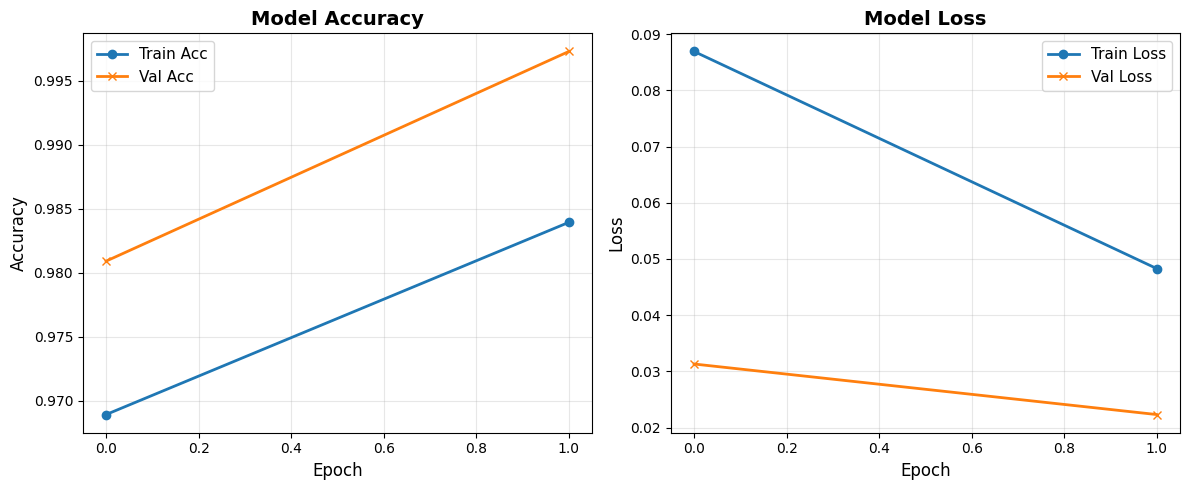


📈 Assignment 9-2 Final Training Results:
   Training Accuracy: 0.9839
   Validation Accuracy: 0.9973
   Training Loss: 0.0483
   Validation Loss: 0.0223

🎯 STARTING INFERENCE WITH EXACT 9-1 LOGIC


In [12]:
import os
import cv2
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, GlobalAveragePooling2D
from keras import Model
from tqdm import tqdm
import pickle
import time

# Paths
image_path = "./Data"
label_dir = "./Data_csv"
MAX_FILE_SIZE_MB = 3
MAX_PROPOSALS = 300

train_images = []
train_labels = []

# ✅ FIXED: Match CSV case exactly
class_map = {"TV": 1, "Remote": 2}

def get_iou(bb1, bb2):
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    inter_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    return inter_area / float(bb1_area + bb2_area - inter_area)

def non_max_suppression(boxes, thresh=0.3):
    """EXACT copy from 9-1"""
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    x1, y1, x2, y2, scores = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3], boxes[:, 4]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)
    pick = []
    while len(idxs) > 0:
        last = idxs[-1]
        pick.append(last)
        xx1 = np.maximum(x1[last], x1[idxs[:-1]])
        yy1 = np.maximum(y1[last], y1[idxs[:-1]])
        xx2 = np.minimum(x2[last], x2[idxs[:-1]])
        yy2 = np.minimum(y2[last], y2[idxs[:-1]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:-1]]
        idxs = np.delete(idxs, np.concatenate(([len(idxs) - 1], np.where(overlap > thresh)[0])))
    return pick  # Return indices instead of boxes[pick].astype("int")

cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# ========================================
# VERIFY CSV FILES BEFORE PROCESSING
# ========================================
print("🔍 VERIFYING CSV FILES BEFORE TRAINING...")
print("="*50)

# Check CSV format and count classes
total_tv = 0
total_remote = 0
csv_files = [f for f in os.listdir(label_dir) if f.endswith(".csv")]
print(f"Found {len(csv_files)} CSV files")

# Sample first few files
for i, csv_file in enumerate(csv_files[:3]):  # Check first 3 files
    print(f"\n📄 Sample CSV: {csv_file}")
    with open(os.path.join(label_dir, csv_file)) as f:
        lines = f.readlines()
        print(f"   Total lines: {len(lines)}")
        print(f"   First line (count): {lines[0].strip()}")
        for j, line in enumerate(lines[1:4]):  # Show first 3 annotations
            print(f"   Line {j+1}: {line.strip()}")

# Count all classes
print("\n📊 Counting all annotations...")
for csv_file in csv_files:
    with open(os.path.join(label_dir, csv_file)) as f:
        lines = f.readlines()[1:]  # Skip first line
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:
                class_name = parts[4]
                if class_name == "TV":
                    total_tv += 1
                elif class_name == "Remote":
                    total_remote += 1

print(f"\n✅ CSV Verification Complete:")
print(f"   Total TV annotations: {total_tv}")
print(f"   Total Remote annotations: {total_remote}")
print(f"   Total annotations: {total_tv + total_remote}")

if total_tv == 0 and total_remote == 0:
    print("\n❌ ERROR: No valid annotations found! Check CSV format.")
    exit()

input("\n👉 Press Enter to continue with training data generation...")
print("="*50)

# Check for cached training data - ASSIGNMENT 9-2 SPECIFIC CACHE
cache_file = "assignment_9_2_training_cache_fixed.npz"  # New cache name to force regeneration
if os.path.exists(cache_file):
    print("🚀 Loading cached training data for Assignment 9-2...")
    cached_data = np.load(cache_file)
    X_new = cached_data['X_new']
    Y_new = cached_data['Y_new']
    print(f"✅ Loaded {len(X_new)} cached training samples")
else:
    print("🔄 Generating training data from scratch for Assignment 9-2...")

    label_files = [f for f in os.listdir(label_dir) if f.endswith(".csv")]

    # Track overall statistics
    files_processed = 0
    total_positives = 0
    total_negatives = 0
    tv_positives = 0
    remote_positives = 0

    for label_file in tqdm(label_files, desc="Preparing training data"):
        try:
            basename = label_file.replace(".csv", "")
            image = None
            for ext in [".jpg", ".jpeg", ".png"]:
                full_path = os.path.join(image_path, basename + ext)
                if os.path.exists(full_path):
                    if os.path.getsize(full_path) > MAX_FILE_SIZE_MB * 1024 * 1024:
                        print(f"⚠️ Skipping {basename+ext} — over 3MB")
                        break
                    image = cv2.imread(full_path)
                    break

            if image is None:
                print(f"❌ Image not found for {basename}")
                continue

            # ✅ FIXED: Use 9-1 style file reading instead of pandas
            with open(os.path.join(label_dir, label_file)) as f:
                lines = f.readlines()[1:]  # Skip first line

            gtvalues = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    print(f"⚠️ Malformed row in {label_file}: {line}")
                    continue
                x1, y1, x2, y2, class_name = parts
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                # ✅ FIXED: No case conversion, match CSV exactly
                class_id = class_map.get(class_name, 0)
                gtvalues.append({"x1": x1, "y1": y1, "x2": x2, "y2": y2, "class": class_id, "name": class_name})

            # Debug first file
            if files_processed == 0 and len(gtvalues) > 0:
                print(f"\n🔍 Debug - First file {label_file}:")
                print(f"   Ground truth boxes: {len(gtvalues)}")
                for i, gt in enumerate(gtvalues[:2]):  # Show first 2
                    print(f"   Box {i}: {gt['name']} at ({gt['x1']},{gt['y1']},{gt['x2']},{gt['y2']})")

            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()

            pos, neg = 0, 0
            pos_tv, pos_remote = 0, 0

            for result in ssresults[:MAX_PROPOSALS]:
                x, y, w, h = result
                patch = image[y:y+h, x:x+w]
                if patch.size == 0:
                    continue
                for gt in gtvalues:
                    iou = get_iou(gt, {"x1": x, "y1": y, "x2": x+w, "y2": y+h})
                    resized = cv2.resize(patch, (224, 224))
                    # ✅ FIXED: Use 0.7 threshold like 9-1
                    if pos < 50 and iou > 0.7:
                        train_images.append(resized)
                        train_labels.append(gt["class"])
                        pos += 1
                        if gt["class"] == 1:
                            pos_tv += 1
                        elif gt["class"] == 2:
                            pos_remote += 1
                    elif neg < 50 and iou < 0.3:
                        train_images.append(resized)
                        train_labels.append(0)
                        neg += 1
                if pos >= 50 and neg >= 50:
                    break

            # Update statistics
            files_processed += 1
            total_positives += pos
            total_negatives += neg
            tv_positives += pos_tv
            remote_positives += pos_remote

        except Exception as e:
            print(f"💥 Error in {label_file}: {e}")

    # Print generation statistics
    print(f"\n📊 Training Data Generation Complete:")
    print(f"   Files processed: {files_processed}")
    print(f"   Total positive samples: {total_positives}")
    print(f"   - TV samples: {tv_positives}")
    print(f"   - Remote samples: {remote_positives}")
    print(f"   Total negative samples: {total_negatives}")
    print(f"   Total samples: {len(train_images)}")

    # Convert and cache
    X_new = np.array(train_images)
    Y_new = tf.keras.utils.to_categorical(train_labels, 3)

    # Save cache with assignment-specific name
    np.savez_compressed(cache_file, X_new=X_new, Y_new=Y_new)
    print(f"💾 Cached {len(X_new)} training samples for Assignment 9-2")

# 🔍 CHECK TRAINING DATA BALANCE
unique, counts = np.unique(np.argmax(Y_new, axis=1), return_counts=True)
class_dict = {}
for i, count in zip(unique, counts):
    if i == 0:
        class_dict['BG'] = int(count)
    elif i == 1:
        class_dict['TV'] = int(count)
    elif i == 2:
        class_dict['Remote'] = int(count)

print(f"\n📊 FINAL Training Data Distribution:")
print(f"   Background: {class_dict.get('BG', 0)}")
print(f"   TV: {class_dict.get('TV', 0)}")
print(f"   Remote: {class_dict.get('Remote', 0)}")
print(f"   Total: {sum(class_dict.values())}")

# Verify we have samples for each class
if class_dict.get('TV', 0) == 0:
    print("\n⚠️ WARNING: No TV training samples!")
if class_dict.get('Remote', 0) == 0:
    print("\n⚠️ WARNING: No Remote training samples!")

input("\n👉 Press Enter to start training with MobileNet...")
print("="*50)

# Always train model fresh (but SAVE for webcam use)
print("🏗️ Training fresh model...")
base_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_new, Y_new, batch_size=16, epochs=2, validation_split=0.1, shuffle=True)

# Save model for webcam application
model_save_path = "assignment_9_2_model.h5"
model.save(model_save_path)
print(f"✅ Model trained and saved to '{model_save_path}' for webcam use")

# Plot training history
print("📊 Plotting training history...")
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='x', linewidth=2)
plt.title("Model Accuracy", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', marker='x', linewidth=2)
plt.title("Model Loss", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("assignment_9_2_training_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

# Print final metrics
print(f"\n📈 Assignment 9-2 Final Training Results:")
print(f"   Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"   Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"   Training Loss: {history.history['loss'][-1]:.4f}")
print(f"   Validation Loss: {history.history['val_loss'][-1]:.4f}")

# === EXACT 9-1 INFERENCE LOGIC ===
print("\n" + "="*50)
print("🎯 STARTING INFERENCE WITH EXACT 9-1 LOGIC")
print("="*50)

✅ Loaded image: ./Data/tv_186.png
🔍 Processing 500 proposals with 9-1 logic...


9-1 style processing: 100%|██████████| 500/500 [00:15<00:00, 33.13it/s]


📊 Found 12 detections with 9-1 logic
✅ After 9-1 NMS: 1 final detections


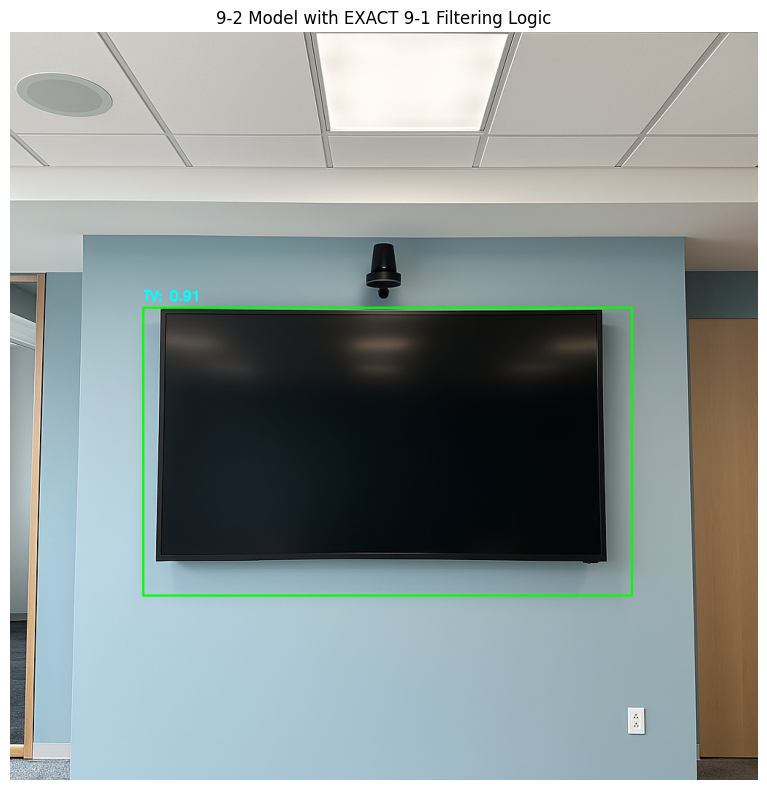


📋 EXACT 9-1 LOGIC RESULTS:
   📺 TVs detected: 1
   📱 Remotes detected: 0
   🎯 Total detections: 1

✅ Using 9-1's exact filtering:
   • Size filter: w≥20, h≥20
   • Confidence: >0.5 AND >background
   • NMS threshold: 0.3
   • No complex shape/position filtering


In [13]:

# Test image setup
test_img_path = "./Data/tv_186.png"  # Test with TV image first
img = cv2.imread(test_img_path)

if img is not None:
    print(f"✅ Loaded image: {test_img_path}")

    # EXACT 9-1 selective search setup
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    proposals = ss.process()[:500]  # Same limit as 9-1

    out_img = img.copy()
    detections = []

    print(f"🔍 Processing {len(proposals)} proposals with 9-1 logic...")

    for (x, y, w, h) in tqdm(proposals, desc="9-1 style processing"):
        # EXACT 9-1 filtering
        if w < 20 or h < 20:  # Same as 9-1
            continue

        roi = img[y:y+h, x:x+w]
        if roi.shape[0] == 0 or roi.shape[1] == 0:
            continue

        resized = cv2.resize(roi, (224, 224))
        resized = np.expand_dims(resized, axis=0)
        pred = model.predict(resized, verbose=0)[0]

        # EXACT 9-1 confidence logic
        bg_prob, tv_prob, remote_prob = pred[0], pred[1], pred[2]
        conf = max(tv_prob, remote_prob)

        # EXACT 9-1 condition: conf > 0.5 AND conf > bg_prob
        if conf > 0.5 and conf > bg_prob:
            label = "TV" if tv_prob > remote_prob else "Remote"
            detections.append([x, y, x + w, y + h, conf, label])

    print(f"📊 Found {len(detections)} detections with 9-1 logic")

    # EXACT 9-1 NMS processing
    filtered = []
    if detections:
        coords = np.array([[x, y, x2, y2, conf] for x, y, x2, y2, conf, _ in detections])
        keep_indices = non_max_suppression(coords, 0.3)  # EXACT 9-1 threshold

        # NMS returns indices, so use them to get the boxes
        for idx in keep_indices:  # ✅ Loop through indices
            if idx < len(coords):
                x1, y1, x2, y2, conf = coords[idx]  # ✅ Use index to get box
                for b in detections:
                    if b[0] == x1 and b[1] == y1 and b[2] == x2 and b[3] == y2:
                        filtered.append(b)
                        break

    print(f"✅ After 9-1 NMS: {len(filtered)} final detections")

    # EXACT 9-1 drawing
    for (x1, y1, x2, y2, conf, label) in filtered:
        color = (0, 255, 0) if label == "TV" else (0, 0, 255)  # Green=TV, Red=Remote
        cv2.rectangle(out_img, (x1, y1), (x2, y2), color, 2)  # Same thickness as 9-1
        cv2.putText(out_img, f"{label}: {conf:.2f}", (x1, y1 - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)  # Same style as 9-1

    # Display results
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
    plt.title("9-2 Model with EXACT 9-1 Filtering Logic")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Summary
    tv_count = sum(1 for _, _, _, _, _, label in filtered if label == "TV")
    remote_count = sum(1 for _, _, _, _, _, label in filtered if label == "Remote")
    print(f"\n📋 EXACT 9-1 LOGIC RESULTS:")
    print(f"   📺 TVs detected: {tv_count}")
    print(f"   📱 Remotes detected: {remote_count}")
    print(f"   🎯 Total detections: {len(filtered)}")
    print(f"\n✅ Using 9-1's exact filtering:")
    print(f"   • Size filter: w≥20, h≥20")
    print(f"   • Confidence: >0.5 AND >background")
    print(f"   • NMS threshold: 0.3")
    print(f"   • No complex shape/position filtering")


🎯 TESTING WITH REMOTE IMAGE
✅ Loaded image: ./Data/remote_test.png


Processing remote image: 100%|██████████| 500/500 [00:13<00:00, 37.19it/s]


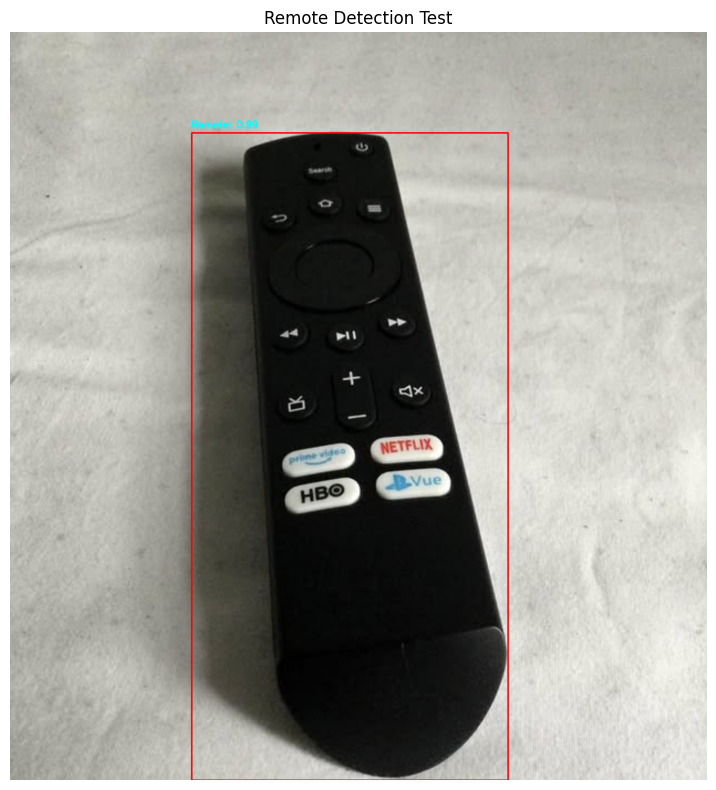

📋 Remote Image Results:
   📺 TVs detected: 0
   📱 Remotes detected: 1
   MobileNet model trained and saved
   Using simple 9-1 filtering for clean results


In [18]:
# === Remote Image Detection Block (Separate from TV) ===

print("\n" + "=" * 50)
print("🎯 TESTING WITH REMOTE IMAGE")
print("=" * 50)

test_img_path2 = "./Data/remote_test.png"
img2 = cv2.imread(test_img_path2)

if img2 is not None:
    print(f"✅ Loaded image: {test_img_path2}")

    ss.setBaseImage(img2)
    ss.switchToSelectiveSearchFast()
    proposals2 = ss.process()[:500]

    out_img2 = img2.copy()
    detections2 = []

    for (x, y, w, h) in tqdm(proposals2, desc="Processing remote image"):
        if w < 20 or h < 20:
            continue

        roi = img2[y:y + h, x:x + w]
        if roi.shape[0] == 0 or roi.shape[1] == 0:
            continue

        resized = cv2.resize(roi, (224, 224))
        resized = np.expand_dims(resized, axis=0)
        pred = model.predict(resized, verbose=0)[0]

        bg_prob, tv_prob, remote_prob = pred[0], pred[1], pred[2]
        conf = max(tv_prob, remote_prob)

        if conf > 0.5 and conf > bg_prob:
            label = "TV" if tv_prob > remote_prob else "Remote"
            detections2.append([x, y, x + w, y + h, conf, label])

    # NMS
    filtered2 = []
    if detections2:
        coords2 = np.array([[x, y, x2, y2, conf] for x, y, x2, y2, conf, _ in detections2])
        keep_indices2 = non_max_suppression(coords2, 0.3)

        for idx in keep_indices2:
            if idx < len(coords2):
                x1, y1, x2, y2, conf = coords2[idx]
                for b in detections2:
                    if b[0] == x1 and b[1] == y1 and b[2] == x2 and b[3] == y2:
                        filtered2.append(b)
                        break

    # Draw detections
    for (x1, y1, x2, y2, conf, label) in filtered2:
        color = (0, 255, 0) if label == "TV" else (0, 0, 255)
        cv2.rectangle(out_img2, (x1, y1), (x2, y2), color, 2)
        cv2.putText(out_img2, f"{label}: {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(out_img2, cv2.COLOR_BGR2RGB))
    plt.title("Remote Detection Test")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    tv_count2 = sum(1 for _, _, _, _, _, label in filtered2 if label == "TV")
    remote_count2 = sum(1 for _, _, _, _, _, label in filtered2 if label == "Remote")

    print(f"📋 Remote Image Results:")
    print(f"   📺 TVs detected: {tv_count2}")
    print(f"   📱 Remotes detected: {remote_count2}")

    print(f"   MobileNet model trained and saved")
    print(f"   Using simple 9-1 filtering for clean results")

else:
    print("❌ Could not load test image")
    print("💡 Make sure the image path is correct")
